shape (17331, 7)
tail           id              date  likes  \
17326  17327  12-12-2020 03:15     56   
17327  17328  09-02-2018 21:47      2   
17328  17329  03-05-2018 14:26    181   
17329  17330  27-01-2020 11:52      0   
17330  17331  10-03-2020 02:58    112   

                                                  tweets        username  \
17326  After 66 years together, this couple died of #...       cbcnewsbc   
17327  Where to add wireless measurements &amp;amp; a...  EMR_Automation   
17328  This is what happened outside a Bromley pollin...     Independent   
17329  Int’l Day Of Education: CSO Sensitises Childre...  IndependentNGR   
17330  Happy Tuesday \nWelcome to #TheMorningFlava\nW...       METROFMSA   

                                                   media inferred company  
17326  [Video(thumbnailUrl='https://pbs.twimg.com/amp...              cbc  
17327  [Photo(previewUrl='https://pbs.twimg.com/media...          emerson  
17328  [Video(thumbnailUrl='https://pbs.twimg.

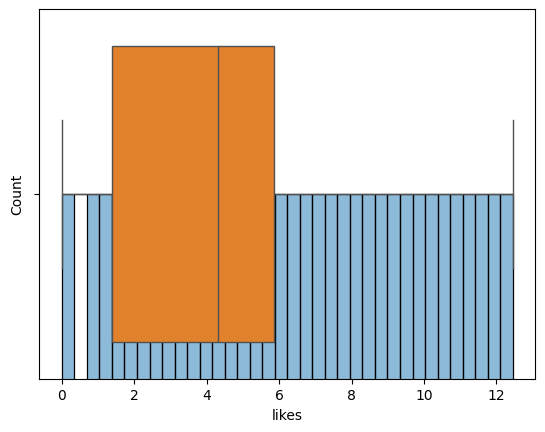

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("behaviour_simulation_train.csv")  # replace with your actual path

print("shape",df.shape)
print("tail",df.tail())
print("info",df.info())
print("nullvalues",df.isnull().sum())

df['likes'] = np.log(df['likes'] + 1)

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['likes'], kde=True)
sns.boxplot(x=df['likes'])



df['tweets'] = df['tweets'].str.lower()

print("lowering_values",df['tweets'].head())





print("describe",df['likes'].describe())





word_dict = df['tweets'].str.split().explode().value_counts().to_dict()



print("shape",df.shape)
print("tail",df.tail())
print("info",df.info())
print("nullvalues",df.isnull().sum())






In [ ]:
#df.dropna(subset=['content', 'username', 'company', 'likes'], inplace=True)
df['media'] = df['media'].fillna('0')
df['has_media'] = df['media'].apply(lambda x: x != 'no_media')

df['datetime'] = pd.to_datetime(df['date'], errors='coerce')







In [ ]:
print("tail",df.tail())


#lowercased, no media term added

tail           id              date     likes  \
17326  17327  12-12-2020 03:15  4.043051   
17327  17328  09-02-2018 21:47  1.098612   
17328  17329  03-05-2018 14:26  5.204007   
17329  17330  27-01-2020 11:52  0.000000   
17330  17331  10-03-2020 02:58  4.727388   

                                                  tweets        username  \
17326  after 66 years together, this couple died of #...       cbcnewsbc   
17327  where to add wireless measurements &amp;amp; a...  EMR_Automation   
17328  this is what happened outside a bromley pollin...     Independent   
17329  int’l day of education: cso sensitises childre...  IndependentNGR   
17330  happy tuesday \nwelcome to #themorningflava\nw...       METROFMSA   

                                                   media inferred company  \
17326  [Video(thumbnailUrl='https://pbs.twimg.com/amp...              cbc   
17327  [Photo(previewUrl='https://pbs.twimg.com/media...          emerson   
17328  [Video(thumbnailUrl='https://pbs.tw

In [ ]:
df['word_count'] = df['tweets'].apply(lambda x: len(x.split()))
df['char_count'] = df['tweets'].apply(len)

print(df['word_count'])
print(df["char_count"])

0        29
1        10
2        14
3        22
4        26
         ..
17326    16
17327    21
17328    23
17329    12
17330    17
Name: word_count, Length: 17331, dtype: int64
0        181
1         73
2        104
3        140
4        199
        ... 
17326    100
17327    173
17328    136
17329     86
17330    141
Name: char_count, Length: 17331, dtype: int64


#TD-IDF

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import math



def calculate_sklearn_tfidf(df, like_thresholds=[1]):
    """
    Calculate TF-IDF using sklearn's TfidfVectorizer
    """
    results = {}

    for threshold in like_thresholds:
        # Filter tweets with likes > threshold
        filtered_df = df[df['likes'] > threshold]

        if len(filtered_df) == 0:
            results[f'likes_>{threshold}'] = {}
            continue

        tweets = filtered_df['tweets'].dropna().tolist()

        if len(tweets) == 0:
            results[f'likes_>{threshold}'] = {}
            continue

        # Use TfidfVectorizer with log scaling
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=None,  # Set to 'english' if you want to remove stop words
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True  # This applies log scaling to TF
        )

        # Fit and transform the tweets
        tfidf_matrix = vectorizer.fit_transform(tweets)
        feature_names = vectorizer.get_feature_names_out()

        # Calculate average TF-IDF scores across all documents
        avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

        # Create dictionary with word: avg_tfidf_score
        word_tfidf = {}
        for i, word in enumerate(feature_names):
            word_tfidf[word] = {
                'avg_tfidf': avg_tfidf_scores[i],
                'idf': vectorizer.idf_[i]
            }

        results[f'likes_>{threshold}'] = word_tfidf

    return results

def display_top_tfidf_words(tfidf_results, top_n=10):
    """
    Display top N words by TF-IDF score for each threshold
    """
    for threshold, words in tfidf_results.items():
        print(f"\n{threshold} - Top {top_n} words by TF-IDF:")
        print("-" * 50)

        if not words:
            print("No data available")
            continue

        # Sort by average TF-IDF score
        sorted_words = sorted(words.items(),
                            key=lambda x: x[1]['avg_tfidf'],
                            reverse=True)[:top_n]

        for word, scores in sorted_words:
          print(f"{word:<15} TF-IDF: {scores['avg_tfidf']:.4f}")

def compare_words_across_thresholds(tfidf_results, words_to_compare):
    """
    Compare specific words across different like thresholds
    """
    print(f"\nComparison of words across thresholds:")
    print("-" * 60)

    # Create header
    thresholds = list(tfidf_results.keys())
    header = f"{'Word':<15}"
    for threshold in thresholds:
        header += f"{threshold:<15}"
    print(header)
    print("-" * 60)

    for word in words_to_compare:
        row = f"{word:<15}"
        for threshold in thresholds:
            if word in tfidf_results[threshold]:
                score = tfidf_results[threshold][word]['avg_tfidf']
                row += f"{score:<15.4f}"
            else:
                row += f"{'N/A':<15}"
        print(row)

# Example usage


sklearn_results = calculate_sklearn_tfidf(df)
display_top_tfidf_words(sklearn_results, top_n=1000)

    # Compare specific words



    # Calculate TF-IDF manually (for understanding)
print("\n" + "="*60)
print("Manual TF-IDF Calculation (for verification)")
print("="*60)








likes_>1 - Top 1000 words by TF-IDF:
--------------------------------------------------
hyperlink       TF-IDF: 0.0530
the             TF-IDF: 0.0427
mention         TF-IDF: 0.0366
to              TF-IDF: 0.0343
and             TF-IDF: 0.0268
in              TF-IDF: 0.0262
of              TF-IDF: 0.0258
for             TF-IDF: 0.0230
you             TF-IDF: 0.0207
on              TF-IDF: 0.0204
is              TF-IDF: 0.0193
with            TF-IDF: 0.0181
this            TF-IDF: 0.0163
it              TF-IDF: 0.0161
at              TF-IDF: 0.0159
we              TF-IDF: 0.0157
your            TF-IDF: 0.0155
our             TF-IDF: 0.0131
from            TF-IDF: 0.0128
are             TF-IDF: 0.0120
that            TF-IDF: 0.0114
more            TF-IDF: 0.0108
new             TF-IDF: 0.0104
all             TF-IDF: 0.0102
be              TF-IDF: 0.0101
now             TF-IDF: 0.0097
here            TF-IDF: 0.0093
get             TF-IDF: 0.0092
by              TF-IDF: 0.0090
amp         

playing with text blob



In [ ]:
from textblob import TextBlob

In [ ]:
word = "i think the movie is very very bad and is a disaster"
TextBlob(word).sentiment.polarity



-0.9099999999999998

In [ ]:
df['sentiment'] = df['tweets'].apply(lambda tweet: 1000*TextBlob(tweet).sentiment.polarity)

print(df['sentiment'])


0        175.0
1          0.0
2       -100.0
3        500.0
4         62.5
         ...  
17326      0.0
17327      0.0
17328      0.0
17329      0.0
17330    800.0
Name: sentiment, Length: 17331, dtype: float64


In [ ]:
print(df['sentiment'].describe())

count    17331.000000
mean       152.968900
std        266.507745
min      -1000.000000
25%          0.000000
50%         53.333333
75%        300.000000
max       1000.000000
Name: sentiment, dtype: float64


In [ ]:
print(df.describe())

                 id         likes                       datetime  \
count  17331.000000  17331.000000                           6832   
mean    8666.000000      3.902128  2019-07-24 10:53:54.651639552   
min        1.000000      0.000000            2018-01-01 06:23:00   
25%     4333.500000      1.386294            2018-11-04 04:02:45   
50%     8666.000000      4.304065            2019-08-10 20:29:30   
75%    12998.500000      5.866468            2020-04-11 12:21:30   
max    17331.000000     12.448752            2020-12-12 23:28:00   
std     5003.173093      2.615391                            NaN   

         word_count    char_count     sentiment  
count  17331.000000  17331.000000  17331.000000  
mean      22.501356    147.868617    152.968900  
min        2.000000     20.000000  -1000.000000  
25%       12.000000     88.000000      0.000000  
50%       21.000000    136.000000     53.333333  
75%       31.000000    202.000000    300.000000  
max       63.000000    323.000000   1

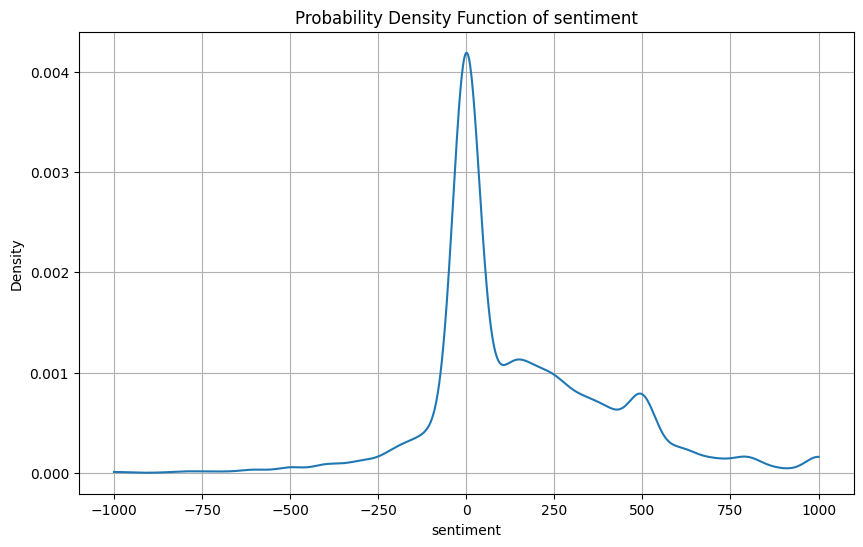

In [ ]:

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np


def plot_pdf(df, feature_name):
    """
    Plots the probability density function for a given feature in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature_name (str): The name of the feature to plot.
    """
    data = df[feature_name].dropna()  # Extract data, removing NaN values
    if len(data) == 0:
        print("No valid data for the selected feature.")
        return

    kde = gaussian_kde(data)  # Create a KDE object
    xs = np.linspace(min(data), max(data), 1000)  # Generate x values for plotting
    density = kde(xs)  # Compute density values

    plt.figure(figsize=(10, 6))
    plt.plot(xs, density)
    plt.title(f'Probability Density Function of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


# Example Usage
# Assuming your DataFrame is named 'df' and your feature is 'my_feature'
# Create a sample DataFrame for demonstration


plot_pdf(df, 'sentiment')

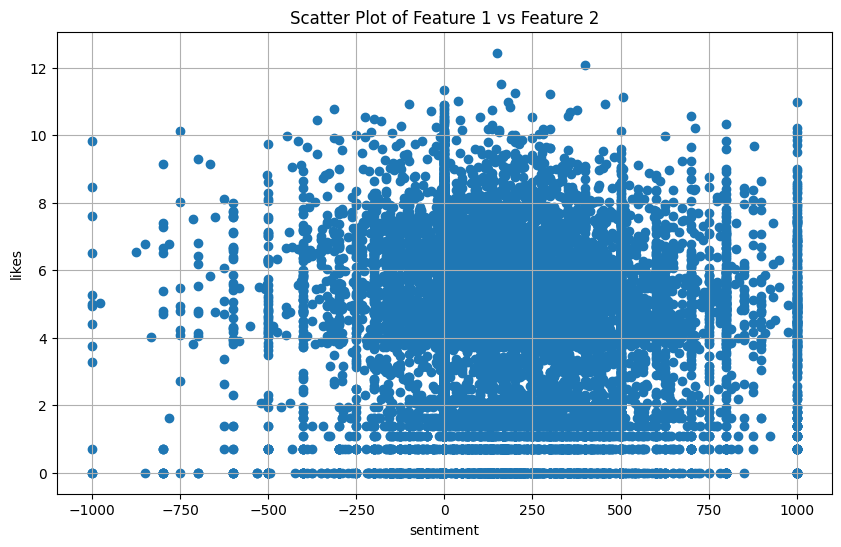

In [ ]:






# Create the scatter plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.scatter(df['sentiment'], df['likes'])

# Add labels and title
plt.xlabel('sentiment')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

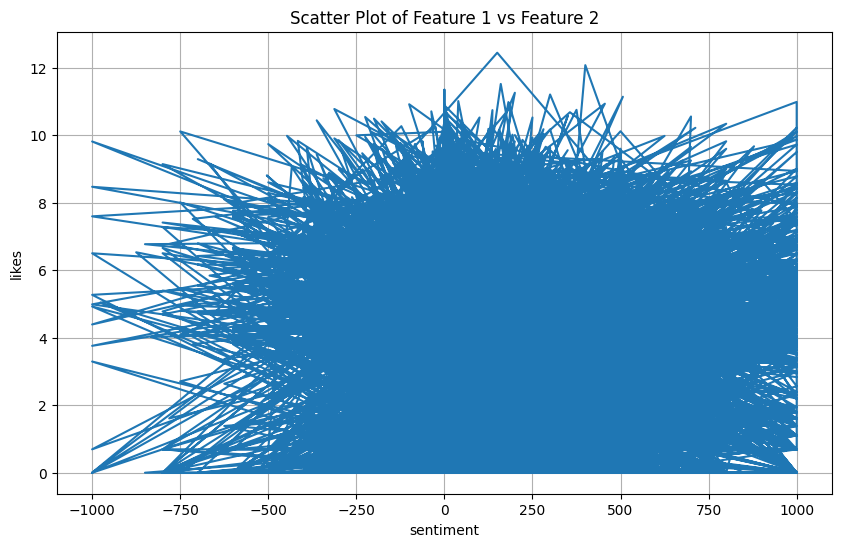

In [ ]:
df_f = df[df['likes'] < 40000]
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df_f['sentiment'], df_f['likes'])

# Add labels and title
plt.xlabel('sentiment')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

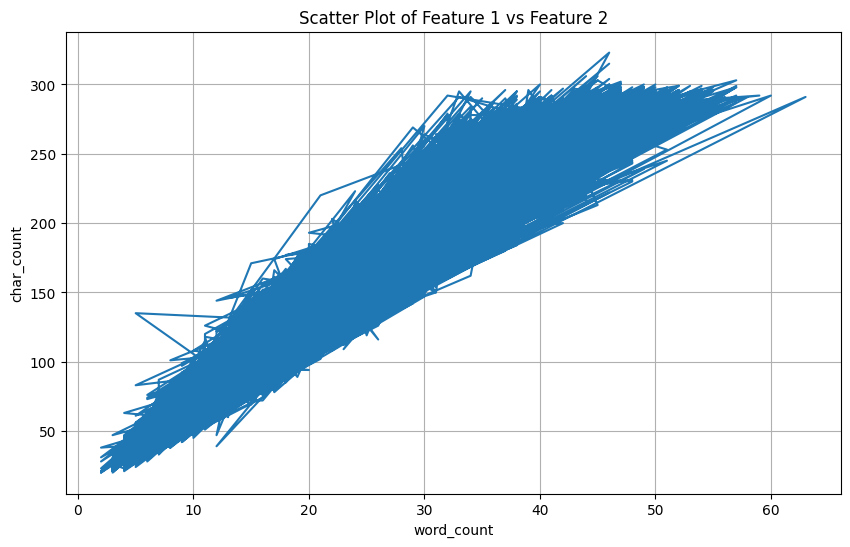

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df['word_count'], df['char_count'])

# Add labels and title
plt.xlabel('word_count')
plt.ylabel('char_count')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

THE PLOT OF SENTIMENT VS LIKES SEEMS LIKE GAUSSIAN


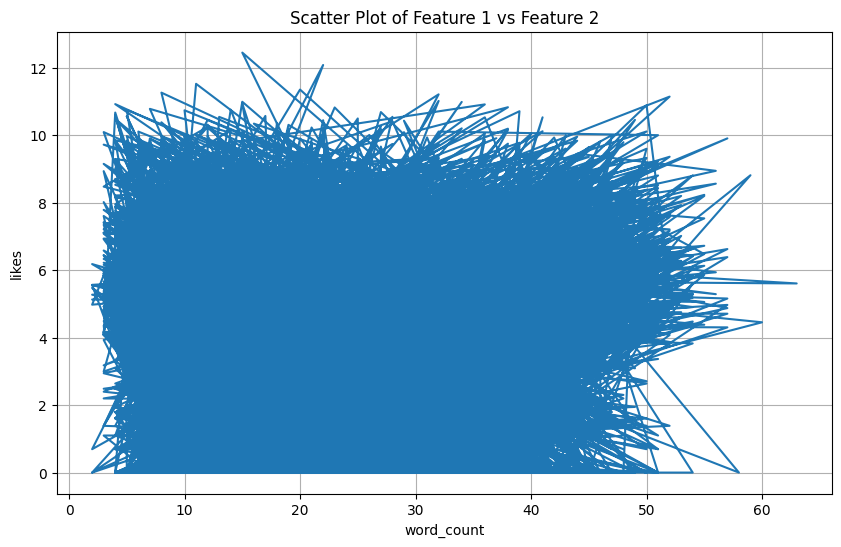

In [ ]:
df_f = df[df['likes'] < 1000000]
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df_f['word_count'], df_f['likes'])

# Add labels and title
plt.xlabel('word_count')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

#Encoding the company names to digits

In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


df['company_encoded'] = le.fit_transform(df['inferred company'])


print(df[['inferred company', 'company_encoded']].head())



  inferred company  company_encoded
0      tim hortons              166
1      independent               87
2              cbc               35
3         williams              189
4      independent               87


In [ ]:
print(df['has_media'])

0        True
1        True
2        True
3        True
4        True
         ... 
17326    True
17327    True
17328    True
17329    True
17330    True
Name: has_media, Length: 17331, dtype: bool


In [ ]:
df['has_media'] = df['has_media'].apply(lambda x: 1 if x else 0)

In [ ]:
print(df.head())

   id              date     likes  \
0   1  12-12-2020 00:47  0.693147   
1   2  30-06-2018 10:04  7.919720   
2   3  29-09-2020 19:47  4.060443   
3   4  01-10-2020 11:40  5.030438   
4   5  19-10-2018 14:30  3.737670   

                                              tweets        username  \
0  spend your weekend morning with a ham, egg, an...    TimHortonsPH   
1  watch rapper <mention> freestyle for over an h...       IndyMusic   
2  canadian armenian community demands ban on mil...       CBCCanada   
3  1st in europe to be devastated by covid-19, it...  MKWilliamsRome   
4  congratulations to pauletha butts of <mention>...           BGISD   

                                               media inferred company  \
0  [Photo(previewUrl='https://pbs.twimg.com/media...      tim hortons   
1  [Photo(previewUrl='https://pbs.twimg.com/media...      independent   
2  [Photo(previewUrl='https://pbs.twimg.com/media...              cbc   
3  [Photo(previewUrl='https://pbs.twimg.com/media...

In [ ]:
df['company_avg_likes'] = df.groupby('inferred company')['likes'].transform('mean')

In [ ]:
df['hashtag'] = df['tweets'].apply(lambda x: 1 if '#' in str(x) else 0)

In [ ]:
avg_likes = df['likes'].mean()
df['likes_adjusted'] = df['likes'].apply(lambda x: avg_likes if x > 50000 else x)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

X = df[['word_count', 'char_count', 'has_media', 'sentiment','company_avg_likes','hashtag']]
y = df['likes_adjusted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds)
print("RMSE:", np.sqrt(rmse))

RMSE: 1.293762390876303


ADDING AVERAGE LIKES BY COMPANY

In [ ]:
print(df['company_avg_likes'])

0        2.622195
1        0.898845
2        4.624000
3        6.245652
4        0.898845
           ...   
17326    4.624000
17327    1.960693
17328    0.898845
17329    0.898845
17330    5.397232
Name: company_avg_likes, Length: 17331, dtype: float64


HASHTAG FEATURE

In [ ]:
print(df['hashtag'])

0        1
1        0
2        0
3        0
4        1
        ..
17326    1
17327    1
17328    0
17329    0
17330    1
Name: hashtag, Length: 17331, dtype: int64


#MORE DATA ANALYSIS ABOUT LIKES DATA

In [ ]:
print(df['likes'].describe())

count    17331.000000
mean         3.902128
std          2.615391
min          0.000000
25%          1.386294
50%          4.304065
75%          5.866468
max         12.448752
Name: likes, dtype: float64


ADDING HIGHEST TD IDF WORK OF THAT TWEET AS KEY WORD OF THAT TWEET AND SEE WHAT HAPPENS


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['tweets'])

# Get feature names (all words)
feature_names = vectorizer.get_feature_names_out()

# Function to get highest TF-IDF word for each tweet
def get_top_tfidf_word(row_index):
    # Get TF-IDF scores for this tweet
    scores = tfidf_matrix[row_index].toarray()[0]

    # Find index of highest score
    top_index = np.argmax(scores)

    # Return the word with highest score
    return feature_names[top_index]

# Create the new column
df['top_keyword'] = [get_top_tfidf_word(i) for i in range(len(df))]

In [ ]:
print(df['top_keyword'])

0          delivery
1              hour
2               ban
3            europe
4        leadership
            ...    
17326          died
17327           amp
17328       station
17329     education
17330       mention
Name: top_keyword, Length: 17331, dtype: object


ADDIGN AVERAG LIKES PER KEYWORD JUST LIKE AVERAGE LIKES PER COMPANY

In [ ]:
# Calculate average likes for each keyword
keyword_avg_likes = df.groupby('top_keyword')['likes'].mean()

# Map the average likes back to each tweet based on its keyword
df['avg_likes_for_keyword'] = df['top_keyword'].map(keyword_avg_likes)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

X = df[['word_count', 'char_count', 'has_media', 'sentiment','company_avg_likes','hashtag','avg_likes_for_keyword']]
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds)
print("RMSE:", np.sqrt(rmse))

RMSE: 1.20356086420511


In [ ]:
import joblib
joblib.dump(model, 'like_predictor.pkl')

['like_predictor.pkl']

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load('like_predictor.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = np.array([
        data['word_count'],
        data['char_count'],
        data['sentiment'],
        data['company_avg_likes'],
        data['hashtag'],
        data['avg_likes_for_keyword']
    ]).reshape(1, -1)

    prediction = model.predict(features)[0]
    return jsonify({'predicted_likes': int(prediction)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def home():
    return "<h1>GFG is great platform to learn</h1>"

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
            

In [ ]:
print("\nPredicted values:", preds)
print("Actual values:", y_test.values)


Predicted values: [1.19264969 4.77648178 1.18423051 ... 3.44133257 0.20253184 7.31496893]
Actual values: [1.94591015 3.97029191 1.38629436 ... 6.52356231 0.         6.55961524]


In [ ]:
preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)

diff = preds_exp - y_test_exp.values


count_p = 0

count_n = 0



for a in diff:
  if a>0:
    count_p+= 1

  else:
    count_n+=1

print(count_p)
print(count_n)

1026
708


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np

X = df[['word_count', 'char_count', 'has_media', 'sentiment','company_avg_likes','hashtag','avg_likes_for_keyword']]
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)

# Apply e^x to both predictions and actual values
preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)

rmse = mean_squared_error(y_test_exp, preds_exp)
print("RMSE:", np.sqrt(rmse))

# Print predictions vs actual values (exponential transformed)
print("\nPredictions vs Actual (e^x applied):")
print("Predicted\tActual")
print("-" * 20)
for i in range(len(preds_exp)):
    print(f"{preds_exp[i]:.2f}\t\t{y_test_exp.iloc[i]:.2f}")



RMSE: 2854.66863732371

Predictions vs Actual (e^x applied):
Predicted	Actual
--------------------
3.28		7.00
133.19		53.00
2.84		4.00
150.66		86.00
86.95		106.00
305.38		125.00
11.44		87.00
147.07		214.00
5.20		3.00
2.73		1.00
144.79		4.00
122.92		58.00
17.04		32.00
94.16		50.00
2.16		3.00
15.48		104.00
4.04		5.00
292.01		129.00
943.97		928.00
139.70		44.00
677.30		238.00
8.40		5.00
125.57		72.00
10.14		10.00
2156.83		1581.00
890.81		635.00
1.00		1.00
24.54		7.00
948.71		870.00
1115.49		1139.00
1782.16		536.00
1004.66		1786.00
1.00		1.00
3.14		4.00
16.96		12.00
3.00		2072.00
6.17		4.00
15.42		30.00
1.17		2.00
5.28		6.00
20.73		34.00
1.32		1.00
6.33		10.00
22.60		1.00
1076.35		845.00
191.47		137.00
1.28		1.00
5.03		11.00
777.87		539.00
905.66		740.00
91.53		185.00
323.44		130.00
4.89		10.00
917.49		2933.00
99.64		225.00
21.24		28.00
973.20		1066.00
1.25		2.00
1888.34		528.00
401.27		196.00
176.45		78.00
633.57		3039.00
400.18		135.00
859.94		1011.00
3.60		2.00
111.73		130.00
1.41		2.00

I HAVE ANALYZED THAT THIS MODEL PREDICTS PRETTY WELL IN RANGES

SO DEFINING RANGES

1-50

50 - 100

100 - 1000

1000 - 5000

5000 - 15000

15000 - 50000

50000 - 1000000000000

In [ ]:
import numpy as np

preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)

# Define ranges
def get_range_category(value):
    if 1 <= value < 100:
        return 1
    elif 100 <= value < 1000:
        return 2
    elif 1000 <= value < 5000:
        return 3
    elif 5000 <= value < 20000:
        return 4
    elif 20000 <= value <100000:
        return 5

    else:
        return 0

count = 0

for i in range(len(preds_exp)):
    pred_range = get_range_category(preds_exp[i])
    actual_range = get_range_category(y_test_exp.iloc[i])

    if pred_range != actual_range:
        count += 1

print(f"Number of range mismatches: {count}")
print(f"Total predictions: {len(preds_exp)}")
print(f"Range accuracy: {(len(preds_exp) - count)/len(preds_exp)*100:.1f}%")

Number of range mismatches: 449
Total predictions: 1734
Range accuracy: 74.1%


In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)

# Filter for actual likes < 10000
mask = y_test_exp < 10000
filtered_preds = preds_exp[mask]
filtered_actual = y_test_exp[mask]

# Calculate MAE for filtered data
mae_filtered = mean_absolute_error(filtered_actual, filtered_preds)

print(np.mean(filtered_actual))
print(np.mean(filtered_preds))

print(f"MAE for likes < 10000: {mae_filtered:.2f}")
print(f"Number of samples with likes < 10000: {len(filtered_actual)}")
print(f"Total samples: {len(y_test_exp)}")

428.77745327102804
339.9236637815956
MAE for likes < 10000: 302.37
Number of samples with likes < 10000: 1712
Total samples: 1734


TILL NOW WE APLLIED ONLY BASIC ML MODELS AND MATH

NOW WE WILL TRY TO USE BERT MODEL WHICH IS ALSO PRETRAINED

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Check for GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load BERT and move to GPU
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)  # Move model to GPU

def get_bert_embeddings_batch_gpu(texts, batch_size=32):  # Increased batch size for GPU
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch and move to GPU
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True,
                          padding=True, max_length=128)

        # Move inputs to GPU
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Get embeddings for batch
        with torch.no_grad():
            outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move back to CPU
            embeddings.extend(batch_embeddings)

    return np.array(embeddings)

# Get BERT features using GPU batch processing
print("Getting BERT embeddings on GPU...")
bert_features = get_bert_embeddings_batch_gpu(df['tweets'].tolist(), batch_size=32)

# Combine with existing features
X_combined = np.concatenate([
    bert_features,  # BERT embeddings (768 dimensions)
    df[['word_count', 'char_count', 'has_media', 'sentiment',
        'company_avg_likes', 'hashtag', 'avg_likes_for_keyword']].values
], axis=1)

# Use with RandomForest
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.1, random_state=42)

print("Training model...")
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions and calculate RMSE
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

Using device: cuda
Getting BERT embeddings on GPU...


KeyboardInterrupt: 

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

def get_bert_embeddings_batch_gpu(texts, batch_size=32):
    embeddings = []
    bert_model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)

    return np.array(embeddings)

total_samples_needed = 17000

if len(df) < total_samples_needed:
    print(f"Warning: Not enough data in your 'df' ({len(df)} samples) to create {total_samples_needed} samples.")
    print("Using all available data for testing the pipeline on a smaller scale.")
    df_sampled = df.copy()
    y_sampled = y.copy()
else:
    available_indices = df.index.values
    sample_indices = np.random.choice(available_indices, total_samples_needed, replace=False)
    df_sampled = df.loc[sample_indices].reset_index(drop=True)
    y_sampled = y[sample_indices]

print(f"Using {len(df_sampled)} samples for BERT embeddings and model training/testing.")

print("Getting BERT embeddings on GPU...")
bert_features = get_bert_embeddings_batch_gpu(df_sampled['tweets'].tolist(), batch_size=32)

X_combined = np.concatenate([
    bert_features,
    df_sampled[['word_count', 'char_count', 'has_media', 'sentiment',
                'company_avg_likes', 'hashtag', 'avg_likes_for_keyword']].values
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_sampled, test_size=500, train_size=16500, random_state=42
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("Training model...")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

Using device: cuda
Using 17000 samples for BERT embeddings and model training/testing.
Getting BERT embeddings on GPU...
X_train shape: (16500, 775), y_train shape: (16500,)
X_test shape: (500, 775), y_test shape: (500,)
Training model...
RMSE: 1.1139107527332677
